In [1]:
from typing_extensions import Literal
from langchain_core.tools import tool
from langchain_groq import ChatGroq
from langgraph.graph import MessagesState, StateGraph, START, END
from langgraph.types import Command
from dotenv import load_dotenv
from IPython.display import Image, display
from langchain_core.messages import BaseMessage, HumanMessage
from typing import Annotated
from langchain_experimental.utilities import PythonREPL
from langchain_community.tools import DuckDuckGoSearchRun
from langgraph.prebuilt import create_react_agent

In [2]:
load_dotenv()

True

In [3]:
groq_model=ChatGroq(model="Gemma2-9b-It")

In [4]:
groq_model.invoke("HI")

AIMessage(content='Hello! 👋  How can I help you today?\n', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 14, 'prompt_tokens': 11, 'total_tokens': 25, 'completion_time': 0.025454545, 'prompt_time': 0.001987686, 'queue_time': 0.24425475400000002, 'total_time': 0.027442231}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run--06c27419-4bb9-43fb-9ed9-c5e1d43595fb-0', usage_metadata={'input_tokens': 11, 'output_tokens': 14, 'total_tokens': 25})

In [5]:
search_tool=DuckDuckGoSearchRun()

In [6]:
search_tool.invoke("what is gdp of india?")

"India is a front-runner among developing economies. Find out how India calculates its GDP, an indicator of economic health and performance. Gross Domestic Product (GDP) is the market worth of all final services and products produced within its boundaries over a certain period. The GDP growth rate is calculated by comparing the GDP of ... Gross Domestic Product (GDP) is the macroeconomic factor that determines a country's economic efficiency and capacity. Check out how to calculate gdp. ... and key details about India's GDP. GDP of India 2025: Highlights . Real GDP Growth for 2025-26 is projected at 6.5%, with quarterly growth estimates: Q1: 6.5%, Q2: 6.7%, Q3: 6.6% and Q4: 6.3%. Annual GDP Estimates and Growth Rates. Real GDP or GDP at Constant Prices is estimated to attain a level of ₹184.88 lakh crore in the financial year 2024-25, against the Provisional Estimate of GDP for the year 2023-24 of ₹173.82 lakh crore. The growth rate in Real GDP during 2024-25 is estimated at 6.4% as co

In [7]:
repl=PythonREPL()

In [8]:
code = """
x = 5
y = x * 2
print(y)
"""

In [9]:
repl.run(code)

Python REPL can execute arbitrary code. Use with caution.


'10\n'

In [10]:
## repl convert to tool
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
<>:14: SyntaxWarning: invalid escape sequence '\`'
C:\Users\mayan\AppData\Local\Temp\ipykernel_20520\3439058093.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
C:\Users\mayan\AppData\Local\Temp\ipykernel_20520\3439058093.py:14: SyntaxWarning: invalid escape sequence '\`'
  result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"


In [11]:

def make_system_prompt(instruction:str)->str:
    return  (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{instruction}"
    )

In [12]:
make_system_prompt(
        "You can only do research. You are working with a chart generator colleague."
    )

"You are a helpful AI assistant, collaborating with other assistants. Use the provided tools to progress towards answering the question. If you are unable to fully answer, that's OK, another assistant with different tools  will help where you left off. Execute what you can to make progress. If you or any of the other assistants have the final answer or deliverable, prefix your response with FINAL ANSWER so the team knows to stop.\nYou can only do research. You are working with a chart generator colleague."

In [13]:
def get_next_node(last_message:BaseMessage, goto:str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [14]:
research_agent = create_react_agent(
    groq_model,
    tools=[search_tool],
    prompt=make_system_prompt(   # by this method appending new line in make_system_prompt. u have seen above
        "You can only do research. You are working with a chart generator colleague."
    ),
)

In [15]:
chart_agent = create_react_agent(
    groq_model,
    [python_repl_tool],
    prompt=make_system_prompt(
        "You can only generate charts. You are working with a researcher colleague."
    ),
)

In [16]:
state={"message":["hi","hello"]}

In [17]:
state["message"][-1]

'hello'

In [18]:
def research_node(state:MessagesState)->Command[Literal["chart_generator", END]]:
    
    result = research_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "chart_generator")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="researcher")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [19]:
def chart_node(state:MessagesState)-> Command[Literal["researcher", END]]:
    
    result = chart_agent.invoke(state)
    
    goto = get_next_node(result["messages"][-1], "researcher")
    
    result["messages"][-1] = HumanMessage(content=result["messages"][-1].content, name="chart_generator")
    
    return Command(update={"messages": result["messages"]},goto=goto)

In [20]:
from langgraph.graph import StateGraph, START

workflow = StateGraph(MessagesState)
workflow.add_node("researcher", research_node)
workflow.add_node("chart_generator", chart_node)

workflow.add_edge(START, "researcher")
app = workflow.compile()

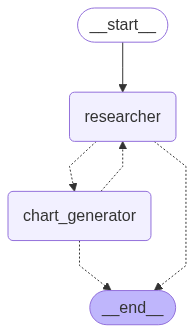

In [21]:
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:

app.invoke({"messages": [("user","get the UK's GDP over the past 3 years, then make a line chart of it.Once you make the chart, finish.")],})